In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install tensorflow matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")   # اسم الملف حسب عندك
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **PreProcessing**

In [20]:
# function

def clean_text(text):
    """
    Clean text and expand contractions to preserve negation.
    This helps the model understand negative sentiment better.
    """
    # Define common contractions
    contractions = {
        "don't": "do not",
        "doesn't": "does not",
        "didn't": "did not",
        "won't": "will not",
        "can't": "can not",
        "cannot": "can not",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "wouldn't": "would not",
        "shouldn't": "should not",
        "couldn't": "could not",
        "mightn't": "might not",
        "mustn't": "must not",
        "i'm": "i am",
        "you're": "you are",
        "he's": "he is",
        "she's": "she is",
        "it's": "it is",
        "we're": "we are",
        "they're": "they are",
        "i've": "i have",
        "you've": "you have",
        "we've": "we have",
        "they've": "they have",
        "i'll": "i will",
        "you'll": "you will",
        "he'll": "he will",
        "she'll": "she will",
        "we'll": "we will",
        "they'll": "they will",
    }

    text = text.lower()

    # Expand contractions BEFORE removing special characters
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    text = re.sub(r"<.*?>", " ", text)          # remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)      # remove special chars
    text = re.sub(r"\s+", " ", text).strip()    # remove double spaces
    return text

# Apply to dataframe
df["review"] = df["review"].apply(clean_text)

# Encode sentiment
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

# **Split data to Train/Test**

In [6]:
X = df["review"].values
y = df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


# **Tokenization**

In [7]:
vocab_size = 20000
max_len = 150

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding="post")


# **Simple RNN**

In [8]:
model = Sequential([
    Input(shape=(max_len,)),
    Embedding(vocab_size, 128),
    SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,217 (9.92 MB)

 Trainable params: 2,601,217 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=64,
    callbacks=[es],
    verbose=2
)


Epoch 1/8
500/500 - 14s - 27ms/step - accuracy: 0.4945 - loss: 0.7085 - val_accuracy: 0.5128 - val_loss: 0.6931
Epoch 2/8
500/500 - 18s - 36ms/step - accuracy: 0.4973 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/8
500/500 - 9s - 17ms/step - accuracy: 0.5055 - loss: 0.6932 - val_accuracy: 0.5011 - val_loss: 0.6932


# **Evaluation**

In [10]:
loss, acc = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Accuracy = {acc * 100:.2f}%")


Test Accuracy = 51.70%


In [11]:
vocab_size = 20000
max_len = 250

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding="post")


# **Build GRU Model**

In [12]:
model = Sequential([
    Input(shape=(max_len,)),
    Embedding(vocab_size, 128),
    GRU(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,393 (10.18 MB)

 Trainable params: 2,667,393 (10.18 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=64,
    callbacks=[es],
    verbose=2
)


Epoch 1/8
500/500 - 248s - 495ms/step - accuracy: 0.5415 - loss: 0.6812 - val_accuracy: 0.5702 - val_loss: 0.6467
Epoch 2/8
500/500 - 245s - 490ms/step - accuracy: 0.7091 - loss: 0.5196 - val_accuracy: 0.8816 - val_loss: 0.2810
Epoch 3/8
500/500 - 243s - 486ms/step - accuracy: 0.9148 - loss: 0.2234 - val_accuracy: 0.8996 - val_loss: 0.2563
Epoch 4/8
500/500 - 243s - 487ms/step - accuracy: 0.9550 - loss: 0.1293 - val_accuracy: 0.8944 - val_loss: 0.3115
Epoch 5/8
500/500 - 243s - 487ms/step - accuracy: 0.9777 - loss: 0.0706 - val_accuracy: 0.8827 - val_loss: 0.3451


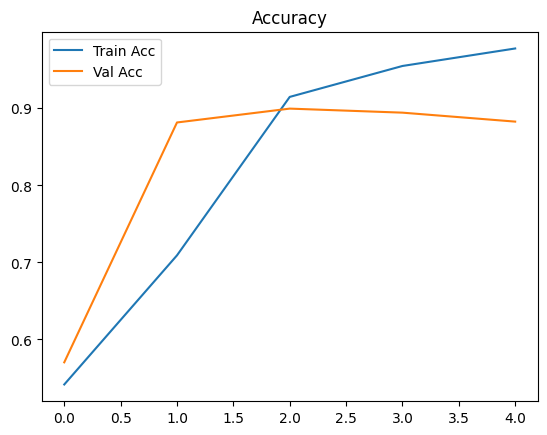

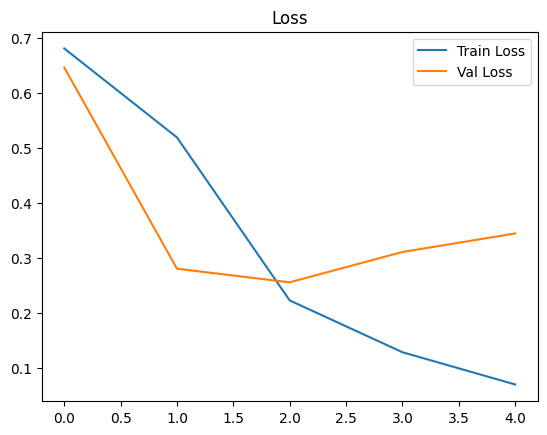

In [14]:
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()


In [15]:
loss, acc = model.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Accuracy = {acc * 100:.2f}%")


Test Accuracy = 89.37%


In [21]:
import joblib
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

class SentimentPipeline:
    def __init__(self, model, tokenizer, max_len):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len

    def predict(self, texts):
        if isinstance(texts, str):
            texts = [texts]

        seqs = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(seqs, maxlen=self.max_len, padding="post")

        preds = self.model.predict(padded, verbose=0)
        return (preds > 0.5).astype(int).ravel()

pipeline = SentimentPipeline(model, tokenizer, max_len)
joblib.dump(pipeline, "pipeline.pkl")

print("💾 Pipeline saved!")

# Test pipeline
loaded_pipeline = joblib.load("pipeline.pkl")
y_pred = loaded_pipeline.predict(X_test)

# Calculate accuracy without sklearn
final_accuracy = (y_pred == y_test).sum() / len(y_test) * 100
print(f"✅ Pipeline Accuracy: {final_accuracy:.2f}%")

# Quick examples
print("\n📝 Quick Examples:")
examples = [
    "I don't like this film at all",
    "This movie was absolutely amazing!",
    "Terrible waste of time"
]

for text in examples:
    pred = loaded_pipeline.predict(clean_text(text))[0]
    sentiment = "😊 POSITIVE" if pred == 1 else "😞 NEGATIVE"
    print(f"   '{text}' → {sentiment}")

💾 Pipeline saved!
✅ Pipeline Accuracy: 89.37%

📝 Quick Examples:
   'I don't like this film at all' → 😊 POSITIVE
   'This movie was absolutely amazing!' → 😊 POSITIVE
   'Terrible waste of time' → 😞 NEGATIVE


In [ ]:
from google.colab import files

files.download('/content/pipeline.pkl')

# **Build Bidirectional GRU Model**

In [22]:
model_bidirectional_gru = Sequential([
    Input(shape=(max_len,)),
    Embedding(vocab_size, 128),
    Bidirectional(GRU(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_bidirectional_gru.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_bidirectional_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,774,657 (10.58 MB)

 Trainable params: 2,774,657 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Bidirectional GRU Model**

In [23]:
es_bidirectional = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_bidirectional = model_bidirectional_gru.fit(
    X_train_padded, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=64,
    callbacks=[es_bidirectional],
    verbose=2
)

Epoch 1/8
500/500 - 436s - 872ms/step - accuracy: 0.7202 - loss: 0.5474 - val_accuracy: 0.8491 - val_loss: 0.3674
Epoch 2/8
500/500 - 439s - 878ms/step - accuracy: 0.8609 - loss: 0.3441 - val_accuracy: 0.8820 - val_loss: 0.2938
Epoch 3/8
500/500 - 428s - 856ms/step - accuracy: 0.9210 - loss: 0.2153 - val_accuracy: 0.8783 - val_loss: 0.3227
Epoch 4/8
500/500 - 428s - 856ms/step - accuracy: 0.9537 - loss: 0.1369 - val_accuracy: 0.8820 - val_loss: 0.3190


# **Evaluate Bidirectional GRU Model**

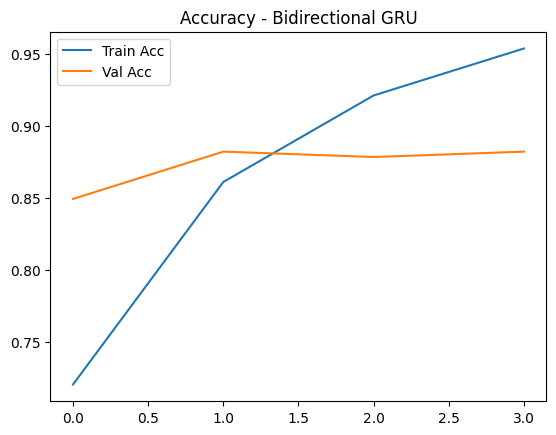

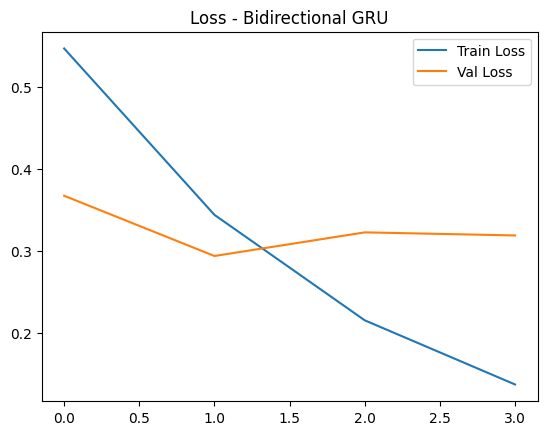

In [24]:
plt.plot(history_bidirectional.history["accuracy"], label="Train Acc")
plt.plot(history_bidirectional.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy - Bidirectional GRU")
plt.legend()
plt.show()

plt.plot(history_bidirectional.history["loss"], label="Train Loss")
plt.plot(history_bidirectional.history["val_loss"], label="Val Loss")
plt.title("Loss - Bidirectional GRU")
plt.legend()
plt.show()

In [25]:
loss_bidirectional, acc_bidirectional = model_bidirectional_gru.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Accuracy for Bidirectional GRU = {acc_bidirectional * 100:.2f}%")

Test Accuracy for Bidirectional GRU = 88.28%


# **Test Bidirectional GRU Pipeline**

In [26]:
# Create a new pipeline with the Bidirectional GRU model
pipeline_bidirectional = SentimentPipeline(model_bidirectional_gru, tokenizer, max_len)
joblib.dump(pipeline_bidirectional, "pipeline_bidirectional.pkl")

print("💾 Bidirectional GRU Pipeline saved!")

# Test pipeline
loaded_pipeline_bidirectional = joblib.load("pipeline_bidirectional.pkl")
y_pred_bidirectional = loaded_pipeline_bidirectional.predict(X_test)

# Calculate accuracy without sklearn
final_accuracy_bidirectional = (y_pred_bidirectional == y_test).sum() / len(y_test) * 100
print(f"✅ Bidirectional GRU Pipeline Accuracy: {final_accuracy_bidirectional:.2f}%")

# Quick examples with the new pipeline
print("\n📝 Quick Examples (Bidirectional GRU):")
examples = [
    "I don't like this film at all",
    "This movie was absolutely amazing!",
    "Terrible waste of time"
]

for text in examples:
    pred = loaded_pipeline_bidirectional.predict(clean_text(text))[0]
    sentiment = "😊 POSITIVE" if pred == 1 else "😞 NEGATIVE"
    print(f"   '{text}' → {sentiment}")

💾 Bidirectional GRU Pipeline saved!
✅ Bidirectional GRU Pipeline Accuracy: 88.28%

📝 Quick Examples (Bidirectional GRU):
   'I don't like this film at all' → 😞 NEGATIVE
   'This movie was absolutely amazing!' → 😊 POSITIVE
   'Terrible waste of time' → 😞 NEGATIVE
